In [1]:
%matplotlib inline

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hbam

from tqdm.notebook import tqdm


results = list()

for i in np.arange(0, 1, 0.01):

    g = nx.erdos_renyi_graph(n=10, p=i)
    a = np.array(nx.adjacency_matrix(g).todense())
    _complexity, _embedding = complexity(a, signature_size=8)
    results.append((i, nx.density(g), _complexity))

df = pd.DataFrame(results, columns=['i','density','complexity'])
df = df.melt(id_vars='i', value_vars=['density','complexity'])

sns.lineplot(x=df.i, y=df.value, hue=df.variable)
plt.show()

# Similarity of networks

The procedure is as follows:

1. Generate a random graph
2. Create a sequence of graphs, where each graph is created
from the previous by nodes/edges additions and deletions
3. Compute the weighted cosine similarities between graphs
4. Correlate the similarities with distances between graphs

In [16]:


ACTIONS = [
    add_node,
    # del_node,
    # add_edge,
    # del_edge
]

NUM_NODES = 50
NUM_ITERATIONS = 50

GRAPHS = []

G1 = nx.erdos_renyi_graph(n=NUM_NODES, p=0.02)
G2 = nx.watts_strogatz_graph(n=NUM_NODES, p=0.01, k=2)
G3 = nx.barabasi_albert_graph(n=NUM_NODES, m=2)

for i in range(NUM_ITERATIONS):
    G1 = np.random.choice(ACTIONS)(G1)
    G2 = np.random.choice(ACTIONS)(G2)
    G3 = np.random.choice(ACTIONS)(G3)
    GRAPHS.append((i, 'erdos', G1))
    GRAPHS.append((i, 'watts', G2))
    GRAPHS.append((i, 'barabasi', G3))

In [17]:
from itertools import combinations

RESULTS = []

# w = np.array([1/(1+i) for i in range(hbam.EMBEDDING_SIZE)])
w = np.array([(hbam.EMBEDDING_SIZE-1)/hbam.EMBEDDING_SIZE for i in range(hbam.EMBEDDING_SIZE)])

for ((ig, tg, g), (ih, th, h)) in tqdm(combinations(GRAPHS, r=2)):
    if tg == th:
        eg = hbam.embed(nx.to_numpy_array(g))
        eh = hbam.embed(nx.to_numpy_array(h))
        RESULTS.append((ih-ig, tg, hbam.cosine(eg, eh, w)))

0it [00:00, ?it/s]

In [18]:
df = pd.DataFrame(RESULTS, columns=['distance', 'family', 'similarity'])
df_g = df.groupby(by=['distance', 'family']).mean().reset_index()

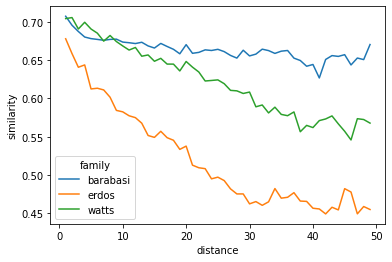

In [19]:
sns.lineplot(x=df_g.distance, y=df_g.similarity, hue=df_g.family)
plt.show()

In [20]:
df_g.describe()

,distance,similarity
count,147.000000,147.000000
mean,25.000000,0.602034
std,14.190485,0.076194
min,1.000000,0.449153
25%,13.000000,0.556774
50%,25.000000,0.634493
75%,37.000000,0.662791
max,49.000000,0.707347


## Graph isomorphism

The idea of the experiment is to generate several isomorphisms of a given graph and then to check the average
cosine similarity between these isomorphic graphs.


In [9]:
ISO_GRAPHS = []
SIMILARITIES = []

g = nx.watts_strogatz_graph(n=100, p=0.02, k=2)
eg = hbam.embed(nx.to_numpy_array(g, nodelist=sorted(g.nodes)))

w = np.array([(hbam.EMBEDDING_SIZE-1)/hbam.EMBEDDING_SIZE for i in range(hbam.EMBEDDING_SIZE)])

for _ in tqdm(range(NUM_ITERATIONS)):
    ISO_GRAPHS.append(hbam.permute(g))

for h in tqdm(ISO_GRAPHS):
    eh = hbam.embed(nx.to_numpy_array(h, nodelist=sorted(h.nodes)))
    SIMILARITIES.append(hbam.cosine(eg, eh, w))

print(SIMILARITIES)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[0.6680407540614977, 0.6237498525865101, 0.656931116879284, 0.6571870189561669, 0.640227977501798, 0.6502955496808303, 0.6792438989226512, 0.6954077916431833, 0.619683282215257, 0.6449986612749476, 0.6653129900946699, 0.6429950117229646, 0.7000218709683813, 0.637801427002772, 0.6946097182273733, 0.670714720434689, 0.643914284255177, 0.6340683909013042, 0.6257893550308744, 0.6591638620779546, 0.6846158433497072, 0.6752783543864584, 0.6575231927749225, 0.6817767869243514, 0.641908455776969, 0.673236206157631, 0.6792050364286563, 0.6819729487186739, 0.6632206980732276, 0.6487780903593492, 0.6293691692148667, 0.6560006693512637, 0.6444646768010402, 0.6858693017558685, 0.6543523596285146, 0.5989675056916939, 0.6656636987332798, 0.6637417397282454, 0.6795465779087714, 0.6325855577527253, 0.6513559255470999, 0.6509155241510871, 0.6299346658490851, 0.6011540694290212, 0.6514517893869023, 0.6528419359923295, 0.6656992101832058, 0.6789438476346277, 0.6722833649434028, 0.6268754751524668]


In [10]:
import itertools

SIMILARITIES = []

for (x, y) in tqdm(itertools.combinations(ISO_GRAPHS, r=2)):
    ex = hbam.embed(nx.to_numpy_array(x, nodelist=[n for n,d in sorted(list(x.degree), key=lambda l: l[1], reverse=True)]))
    ey = hbam.embed(nx.to_numpy_array(y, nodelist=[n for n,d in sorted(list(y.degree), key=lambda l: l[1], reverse=True)]))
    SIMILARITIES.append(hbam.cosine(ex, ey, w))

print(SIMILARITIES)

0it [00:00, ?it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [11]:
np.mean(SIMILARITIES)

1.0